In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
%matplotlib inline

In [2]:
def brute_force_correlation_processing() :
    df = pd.read_csv('./dataset/Paribas-Cardif-Claim-Data/train.csv', nrows=50000)
    print(df.shape)
    print(df.head())
    
    # Get Numerical features from dataset
    numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64']
    numerical_features = list(df.select_dtypes(include=numerics).columns)
    
    data = df[numerical_features]
    print ("Dropping the non numeric data : ",data.shape," is the shape")
    print(data.head())
    
    X = data.drop(['target', 'ID'], axis=1)
    print("Dropping off target and ID : ",X.shape)
    
    
    # Visualize Correlated Features
    print ("Visualizing the correlation features : ")
    corr = X.corr()
    fig, ax = plt.subplots()
    fig.set_size_inches(11,11)
    sns.heatmap(corr)
    
    # Brute Force Method to find Correlation between features
    def correlation(data, threshold=None):
        # Set of all names of correlated columns
        col_corr = set()
        corr_mat = data.corr()
        for i in range(len(corr_mat.columns)):
            for j in range(i):
                if (abs(corr_mat.iloc[i,j]) > threshold):
                    colname = corr_mat.columns[i]
                    col_corr.add(colname)
        return col_corr
    
    correlated_features = correlation(data=X, threshold=0.8)
    print ("Features correlated with each other in dataaset : ", len(set(correlated_features)))
    
    print ("Drpping these features ...")
    
    X.drop(labels=correlated_features, axis=1, inplace=True)
    
    X.to_csv(r'./dataset/brute_force_corr_processed.csv')

In [3]:
def highly_correlated_feature_group() :
    df = pd.read_csv('./dataset/Paribas-Cardif-Claim-Data/train.csv', nrows=50000)
    print(df.shape)
    print(df.head())
    
    # Get Numerical features from dataset
    numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64']
    numerical_features = list(df.select_dtypes(include=numerics).columns)
    pd.options.mode.chained_assignment = None
    data = df[numerical_features]
    print ("Dropping the non numeric data : ",data.shape," is the shape")
    print(data.head())
    
    X = data.drop(['target', 'ID'], axis=1)
    print("Dropping off target and ID : ",X.shape)
    
    # Build a Dataframe with Correlation between Features
    corr_matrix = X.corr()
    # Take absolute values of correlated coefficients
    corr_matrix = corr_matrix.abs().unstack()
    corr_matrix = corr_matrix.sort_values(ascending=False)
    # Take only features with correlation above threshold of 0.8
    corr_matrix = corr_matrix[corr_matrix >= 0.8]
    corr_matrix = corr_matrix[corr_matrix < 1]
    corr_matrix = pd.DataFrame(corr_matrix).reset_index()
    corr_matrix.columns = ['feature1', 'feature2', 'Correlation']
    print("Correlation matrix \n : ",corr_matrix.head())

    # Get groups of features that are correlated amongs themselves
    grouped_features = []
    correlated_groups = []

    for feature in corr_matrix.feature1.unique():
        if feature not in grouped_features:
            # Find all features correlated to a single feature
            correlated_block = corr_matrix[corr_matrix.feature1 == feature]
            grouped_features = grouped_features + list(correlated_block.feature2.unique()) + [feature]

            # Append block of features to the list
            correlated_groups.append(correlated_block)

    print('Found {} correlated feature groups'.format(len(correlated_groups)))
    print('out of {} total features.'.format(X.shape[1]))
    
    for group in correlated_groups:
        print(group)
        print('\n')
        
    # Investigating features further within one group
    group = correlated_groups[3]
    print(group)
    
    # Select features with less missing data
    for features in list(group.feature2.unique()) + ['v17']:
        print(X[feature].isnull().sum())
    
    print ("Using Random forest classifier to find best features : ")
    y = data['target']
    y.shape
        # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    from sklearn.ensemble import RandomForestClassifier

    features = list(group.feature2.unique()) + ['v17']
    rfc = RandomForestClassifier(n_estimators=20, random_state=101, max_depth=4)
    rfc.fit(X_train[features].fillna(0), y_train)

        # Get Feature Importance using RFC
    importance = pd.concat([pd.Series(features), pd.Series(rfc.feature_importances_)], axis=1)
    importance.columns = ['feature', 'importance']
    importance.sort_values(by='importance', ascending=False)
    
    to_drop = set()
    for i in ('v8','v105','v54','v63','v25','v89') :
        to_drop.add(i)
    
    X_train.drop(labels=to_drop, axis=1, inplace=True)
    X_test.drop(labels=to_drop, axis=1, inplace=True)

    X=pd.merge(X_train,X_test)
    X.to_csv(r'./dataset/Highly_corr_group_processed.csv')
    
    

In [4]:
def remove_duplicate () :
    df = pd.read_csv('./dataset/Paribas-Cardif-Claim-Data/train.csv', nrows=50000)
    print(df.shape)
    print(df.head())
    
    # Get Numerical features from dataset
    numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64']
    numerical_features = list(df.select_dtypes(include=numerics).columns)
    
    data = df[numerical_features]
    print ("Dropping the non numeric data : ",data.shape," is the shape")
    print(data.head())
    
    X = data.drop(['target', 'ID'], axis=1)
    print("Dropping off target and ID : ",X.shape)
    
    duplicated_feat = []
    for i in range(0, len(X.columns)):
        if i % 10 == 0:  # this helps me understand how the loop is going
            print(i)

        col_1 = X.columns[i]

        for col_2 in X.columns[i + 1:]:
            if X[col_1].equals(X[col_2]):
                duplicated_feat.append(col_2)

    print("Number of duplicate freatures : ",len(duplicated_feat))
    
    X.drop(labels=duplicated_feat, axis=1, inplace=True)
    
    X.to_csv(r'./dataset/removed_duplicates_processed.csv')

In [5]:
def fisher_score_chi_square() :
    df = pd.read_csv('./dataset/Paribas-Cardif-Claim-Data/train.csv', nrows=50000)
    
    df.boxplot('target','v75',rot = 30,figsize=(5,6))
    df.boxplot('target','v52',rot = 30,figsize=(5,6))
    df.boxplot('target','v125',rot = 30,figsize=(5,6))
    df.boxplot('target','v91',rot = 30,figsize=(5,6))
    df.boxplot('target','v107',rot = 30,figsize=(5,6))
    
    print ("\nGetting to know categorical data") 
    
    cat_df = df.select_dtypes(include=['object']).copy()
    
    print (cat_df.head())
    
        # Encode categorical variables into numbers
    label1 = {k:i for i, k in enumerate(df['v3'].unique(),0)}
    label2 = {k:i for i, k in enumerate(df['v22'].unique(),0)}
    label3 = {k:i for i, k in enumerate(df['v24'].unique(),0)}
    label4 = {k:i for i, k in enumerate(df['v30'].unique(),0)}
    label5 = {k:i for i, k in enumerate(df['v31'].unique(),0)}
    label6 = {k:i for i, k in enumerate(df['v47'].unique(),0)}
    label7 = {k:i for i, k in enumerate(df['v52'].unique(),0)}
    label8 = {k:i for i, k in enumerate(df['v56'].unique(),0)}
    label9 = {k:i for i, k in enumerate(df['v66'].unique(),0)}
    label10 = {k:i for i, k in enumerate(df['v71'].unique(),0)}
    label11 = {k:i for i, k in enumerate(df['v74'].unique(),0)}
    label12 = {k:i for i, k in enumerate(df['v75'].unique(),0)}
    label13 = {k:i for i, k in enumerate(df['v79'].unique(),0)}
    label14 = {k:i for i, k in enumerate(df['v91'].unique(),0)}
    label15 = {k:i for i, k in enumerate(df['v107'].unique(),0)}
    label16 = {k:i for i, k in enumerate(df['v110'].unique(),0)}
    label17 = {k:i for i, k in enumerate(df['v112'].unique(),0)}
    label18 = {k:i for i, k in enumerate(df['v113'].unique(),0)}
    label19 = {k:i for i, k in enumerate(df['v125'].unique(),0)}

    df['v3'] = df['v3'].map(label1)
    df['v22'] = df['v22'].map(label2)
    df['v24'] = df['v24'].map(label3)
    df['v30'] = df['v30'].map(label4)
    df['v31'] = df['v31'].map(label5)
    df['v47'] = df['v47'].map(label6)
    df['v52'] = df['v52'].map(label7)
    df['v56'] = df['v56'].map(label8)
    df['v66'] = df['v66'].map(label9)
    df['v71'] = df['v71'].map(label10)
    df['v74'] = df['v74'].map(label11)
    df['v75'] = df['v75'].map(label12)
    df['v79'] = df['v79'].map(label13)
    df['v91'] = df['v91'].map(label14)
    df['v107'] = df['v107'].map(label15)
    df['v110'] = df['v110'].map(label16)
    df['v112'] = df['v112'].map(label17)
    df['v113'] = df['v113'].map(label18)
    df['v125'] = df['v125'].map(label19)
    
    X = df[['v3','v22','v24','v30','v31','v47','v52','v56','v66','v71','v74','v75','v79','v91','v107','v110','v112','v113','v125']]
    print(X.head())
    
    # Train Test Split
    y = df['target']
    y.shape
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    X_train.shape, y_train.shape, X_test.shape, y_test.shape
    
    # Calcualte the Fisher Score (chi2) between each feature and target
    fisher_score = chi2(X_train.fillna(0), y_train)
    fisher_score
    
    p_values = pd.Series(fisher_score[1])
    p_values.index = X_train.columns
    p2 = p_values.sort_values(ascending=True)
    
    print (p2.index[0]," is the most important feature here")
    
    return (p2.index[0])

In [6]:
def mutual_info_using_classification() :
    df = pd.read_csv('./dataset/Paribas-Cardif-Claim-Data/train.csv', nrows=50000)
    print(df.shape)
    print(df.head())
    
    # Get Numerical features from dataset
    numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64']
    numerical_features = list(df.select_dtypes(include=numerics).columns)
    pd.options.mode.chained_assignment = None
    data = df[numerical_features]
    print ("Dropping the non numeric data : ",data.shape," is the shape")
    print(data.head())
    
    X = data.drop(['target', 'ID'], axis=1)
    print("Dropping off target and ID : ",X.shape)
    
    y = data['target']
    y.head()
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    X_train.shape, y_train.shape, X_test.shape, y_test.shape
    
    # Calculate Mutual Information between each feature and the target
    mutual_info = mutual_info_classif(X_train.fillna(0), y_train)
    mutual_info
    
    # Create Feature Target Mutual Information Series
    mi_series = pd.Series(mutual_info)
    mi_series.index = X_train.columns
    mi_series.sort_values(ascending=False)
    
    mi_series.sort_values(ascending=False).plot.bar(figsize=(20,8))
    
    # Select K best features
    k_best_features = SelectKBest(mutual_info_classif, k=10).fit(X_train.fillna(0), y_train)
    print('Selected top 10 features: {}'.format(X_train.columns[k_best_features.get_support()]))
    l = X_train.columns[k_best_features.get_support()]
    return (l)
    

In [7]:
def mutual_info_using_regression() :
    df = pd.read_csv('./dataset/Paribas-Cardif-Claim-Data/train.csv', nrows=50000)
    print(df.shape)
    print(df.head())
    
    # Get Numerical features from dataset
    numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64']
    numerical_features = list(df.select_dtypes(include=numerics).columns)
    pd.options.mode.chained_assignment = None
    data = df[numerical_features]
    print ("Dropping the non numeric data : ",data.shape," is the shape")
    print(data.head())
    
    pd.options.mode.chained_assignment = None
    
    X = data.drop(['target', 'ID'], axis=1)
    print("Dropping off target and ID : ",X.shape)
    
    y = data['target']
    y.head()
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    X_train.shape, y_train.shape, X_test.shape, y_test.shape
    
    # Mutual Information Regressor
    # Calculate Mutual Information between each feature and the target
    mutual_info = mutual_info_regression(X_train.fillna(0), y_train)
    mutual_info
    
    # Create Feature Target Mutual Information Series
    mi_series = pd.Series(mutual_info)
    mi_series.index = X_train.columns
    mi_series.sort_values(ascending=False)
    
    mi_series.sort_values(ascending=False).plot.bar(figsize=(20,8))
    # Select K best features
    k_percentile_features = SelectPercentile(mutual_info_classif, percentile=10).fit(X_train.fillna(0), y_train)
    print('Selected top 10 percentile features: {}'.format(X_train.columns[k_percentile_features.get_support()]))
    
    return(X_train.columns[k_percentile_features.get_support()])

(50000, 133)
   ID  target        v1        v2 v3        v4         v5        v6        v7  \
0   3       1  1.335739  8.727474  C  3.921026   7.915266  2.599278  3.176895   
1   4       1       NaN       NaN  C       NaN   9.191265       NaN       NaN   
2   5       1  0.943877  5.310079  C  4.410969   5.326159  3.979592  3.928571   
3   6       1  0.797415  8.304757  C  4.225930  11.627438  2.097700  1.987549   
4   8       1       NaN       NaN  C       NaN        NaN       NaN       NaN   

         v8    ...         v122      v123      v124  v125      v126      v127  \
0  0.012941    ...     8.000000  1.989780  0.035754    AU  1.804126  3.113719   
1  2.301630    ...          NaN       NaN  0.598896    AF       NaN       NaN   
2  0.019645    ...     9.333333  2.477596  0.013452    AE  1.773709  3.922193   
3  0.171947    ...     7.018256  1.812795  0.002267    CJ  1.415230  2.954381   
4       NaN    ...          NaN       NaN       NaN     Z       NaN       NaN   

       v128  

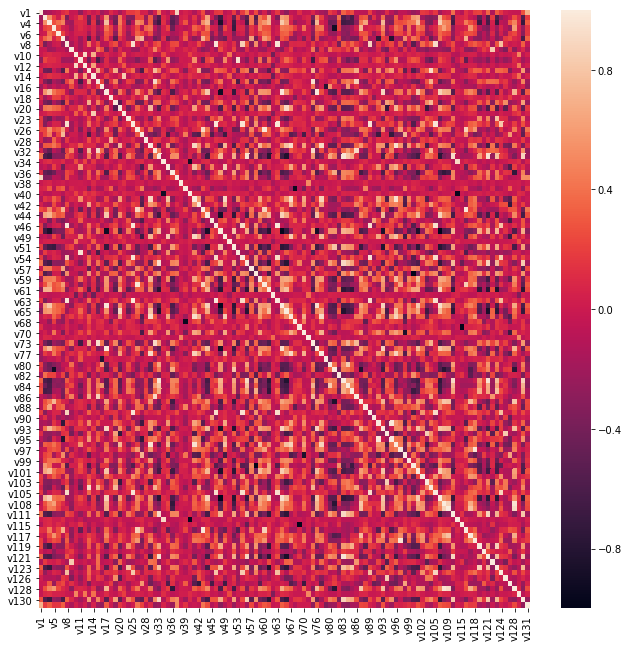

In [8]:
brute_force_correlation_processing()

In [9]:
highly_correlated_feature_group()

(50000, 133)
   ID  target        v1        v2 v3        v4         v5        v6        v7  \
0   3       1  1.335739  8.727474  C  3.921026   7.915266  2.599278  3.176895   
1   4       1       NaN       NaN  C       NaN   9.191265       NaN       NaN   
2   5       1  0.943877  5.310079  C  4.410969   5.326159  3.979592  3.928571   
3   6       1  0.797415  8.304757  C  4.225930  11.627438  2.097700  1.987549   
4   8       1       NaN       NaN  C       NaN        NaN       NaN       NaN   

         v8    ...         v122      v123      v124  v125      v126      v127  \
0  0.012941    ...     8.000000  1.989780  0.035754    AU  1.804126  3.113719   
1  2.301630    ...          NaN       NaN  0.598896    AF       NaN       NaN   
2  0.019645    ...     9.333333  2.477596  0.013452    AE  1.773709  3.922193   
3  0.171947    ...     7.018256  1.812795  0.002267    CJ  1.415230  2.954381   
4       NaN    ...          NaN       NaN       NaN     Z       NaN       NaN   

       v128  

In [11]:
remove_duplicate ()

(50000, 133)
   ID  target        v1        v2 v3        v4         v5        v6        v7  \
0   3       1  1.335739  8.727474  C  3.921026   7.915266  2.599278  3.176895   
1   4       1       NaN       NaN  C       NaN   9.191265       NaN       NaN   
2   5       1  0.943877  5.310079  C  4.410969   5.326159  3.979592  3.928571   
3   6       1  0.797415  8.304757  C  4.225930  11.627438  2.097700  1.987549   
4   8       1       NaN       NaN  C       NaN        NaN       NaN       NaN   

         v8    ...         v122      v123      v124  v125      v126      v127  \
0  0.012941    ...     8.000000  1.989780  0.035754    AU  1.804126  3.113719   
1  2.301630    ...          NaN       NaN  0.598896    AF       NaN       NaN   
2  0.019645    ...     9.333333  2.477596  0.013452    AE  1.773709  3.922193   
3  0.171947    ...     7.018256  1.812795  0.002267    CJ  1.415230  2.954381   
4       NaN    ...          NaN       NaN       NaN     Z       NaN       NaN   

       v128  


Getting to know categorical data
  v3   v22 v24  v30 v31 v47 v52  v56 v66 v71 v74 v75 v79 v91 v107 v110 v112  \
0  C   XDX   C    C   A   C   G   DI   C   F   B   D   E   A    E    B    O   
1  C   GUV   C    C   A   E   G   DY   A   F   B   D   D   B    B    A    U   
2  C    FQ   E  NaN   A   C   F   AS   A   B   B   B   E   G    C    B    S   
3  C  ACUE   D    C   B   C   H   BW   A   F   B   D   B   B    B    B    J   
4  C   HIT   E  NaN   A   I   H  NaN   C   F   B   D   C   G    C    A    T   

  v113 v125  
0  NaN   AU  
1    G   AF  
2  NaN   AE  
3  NaN   CJ  
4    G    Z  
   v3  v22  v24  v30  v31  v47  v52  v56  v66  v71  v74  v75  v79  v91  v107  \
0   0    0    0    0    0    0    0    0    0    0    0    0    0    0     0   
1   0    1    0    0    0    1    0    1    1    0    0    0    1    1     1   
2   0    2    1    1    0    0    1    2    1    1    0    1    0    2     2   
3   0    3    2    0    1    0    2    3    1    0    0    0    2    1     1   
4   0  

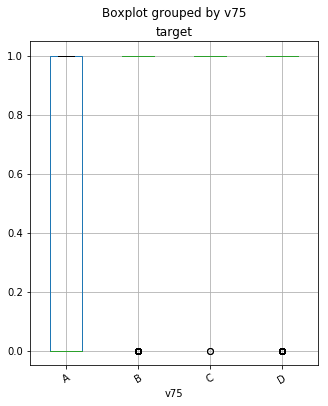

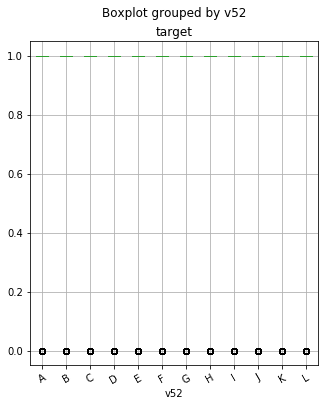

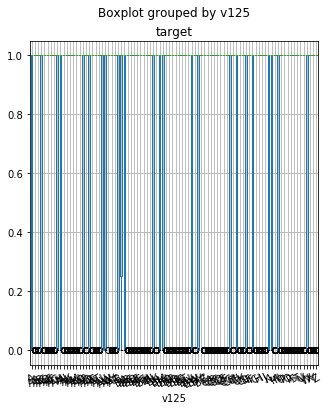

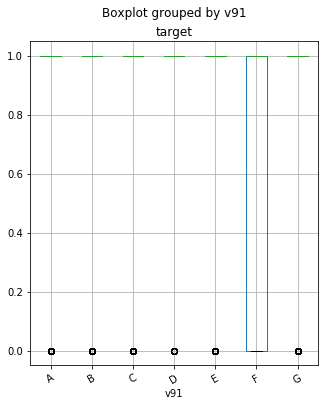

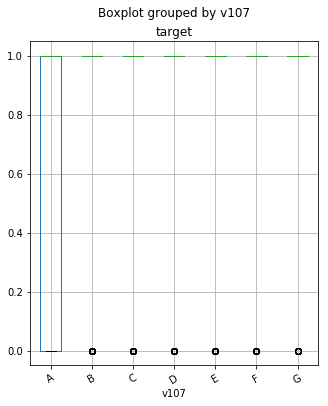

In [12]:
most_imp_feature = fisher_score_chi_square()

In [13]:
most_imp_feature

'v22'

(50000, 133)
   ID  target        v1        v2 v3        v4         v5        v6        v7  \
0   3       1  1.335739  8.727474  C  3.921026   7.915266  2.599278  3.176895   
1   4       1       NaN       NaN  C       NaN   9.191265       NaN       NaN   
2   5       1  0.943877  5.310079  C  4.410969   5.326159  3.979592  3.928571   
3   6       1  0.797415  8.304757  C  4.225930  11.627438  2.097700  1.987549   
4   8       1       NaN       NaN  C       NaN        NaN       NaN       NaN   

         v8    ...         v122      v123      v124  v125      v126      v127  \
0  0.012941    ...     8.000000  1.989780  0.035754    AU  1.804126  3.113719   
1  2.301630    ...          NaN       NaN  0.598896    AF       NaN       NaN   
2  0.019645    ...     9.333333  2.477596  0.013452    AE  1.773709  3.922193   
3  0.171947    ...     7.018256  1.812795  0.002267    CJ  1.415230  2.954381   
4       NaN    ...          NaN       NaN       NaN     Z       NaN       NaN   

       v128  

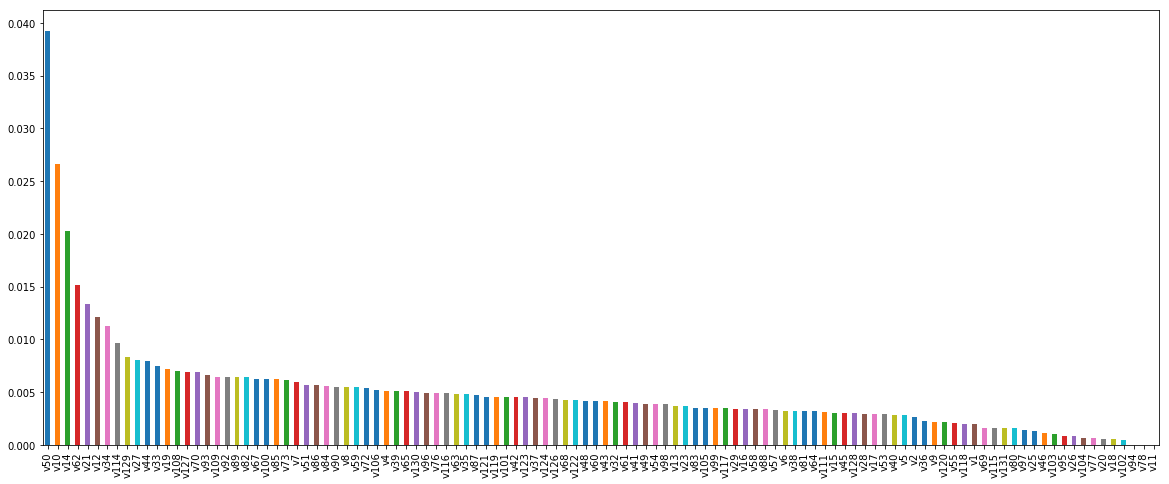

In [14]:
selected_features=mutual_info_using_classification()

In [15]:
print(selected_features)

Index(['v10', 'v12', 'v14', 'v21', 'v34', 'v44', 'v50', 'v62', 'v114', 'v129'], dtype='object')


In [ ]:
selected_features = mutual_info_using_regression()

(50000, 133)
   ID  target        v1        v2 v3        v4         v5        v6        v7  \
0   3       1  1.335739  8.727474  C  3.921026   7.915266  2.599278  3.176895   
1   4       1       NaN       NaN  C       NaN   9.191265       NaN       NaN   
2   5       1  0.943877  5.310079  C  4.410969   5.326159  3.979592  3.928571   
3   6       1  0.797415  8.304757  C  4.225930  11.627438  2.097700  1.987549   
4   8       1       NaN       NaN  C       NaN        NaN       NaN       NaN   

         v8    ...         v122      v123      v124  v125      v126      v127  \
0  0.012941    ...     8.000000  1.989780  0.035754    AU  1.804126  3.113719   
1  2.301630    ...          NaN       NaN  0.598896    AF       NaN       NaN   
2  0.019645    ...     9.333333  2.477596  0.013452    AE  1.773709  3.922193   
3  0.171947    ...     7.018256  1.812795  0.002267    CJ  1.415230  2.954381   
4       NaN    ...          NaN       NaN       NaN     Z       NaN       NaN   

       v128  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
print (selected_features)